In [84]:
import sys
dir_path = '../src/'
sys.path.append(dir_path)
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import tqdm
import config
import logging
import os
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error

# Data preprocessing

In [153]:
logger = logging.getLogger('log')
logger.setLevel(logging.INFO)
pio.renderers.default = "notebook_connected"

##### Load data from 'Datos'

In [154]:
df_maestro_producto = pd.read_csv('../input/Datos_maestro_producto.csv')
df_maestro_producto

,PRODUCTO,MARCA
0,A1,MARCA1
1,A2,MARCA2
2,A3,MARCA2
3,A4,MARCA1
4,A5,MARCA3
5,A6,MARCA3
6,A7,MARCA3
7,A8,MARCA1
8,A9,MARCA1
9,A10,MARCA1


In [155]:
df_precios = pd.read_csv('../input/Datos_precios.csv')
config.date_format(df_precios)  #reformat column type (int to datetime)
df_precios

,MES/AÑO,TIPO CLIENTES,PRODUCTO,PRECIO POR TON (USD)
0,2018-01-01,CLIENTES GRANDES,A1,11974.78
1,2018-01-01,CLIENTES GRANDES,A2,16001.06
2,2018-01-01,CLIENTES GRANDES,A3,17422.30
3,2018-01-01,CLIENTES GRANDES,A4,13909.82
4,2018-01-01,CLIENTES GRANDES,A5,16142.56
...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,10749.63
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,8750.97
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,16789.52
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,12336.52


In [156]:
df_inversiones = pd.read_csv('../input/Datos_inversiones.csv')
config.date_format(df_inversiones)  #reformat column type (int to datetime)
df_inversiones

,MES/AÑO,TIPO CLIENTES,PRODUCTO,INVERSION
0,2018-01-01,CLIENTES GRANDES,A1,0.3296
1,2018-01-01,CLIENTES GRANDES,A2,0.2392
2,2018-01-01,CLIENTES GRANDES,A3,0.2552
3,2018-01-01,CLIENTES GRANDES,A4,0.2642
4,2018-01-01,CLIENTES GRANDES,A5,0.2246
...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,0.3324
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,0.2366
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,0.1711
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,0.4000


In [157]:
df_coberturas = pd.read_csv('../input/Datos_coberturas.csv')
config.date_format(df_coberturas)  #reformat column type (int to datetime)
df_coberturas['% TIENDAS IMPACTADAS'] = df_coberturas['% TIENDAS IMPACTADAS'] / 100  #Reescale column to %
df_coberturas

,MES/AÑO,TIPO CLIENTES,PRODUCTO,% TIENDAS IMPACTADAS
0,2018-01-01,CLIENTES GRANDES,A1,0.93
1,2018-01-01,CLIENTES GRANDES,A2,1.00
2,2018-01-01,CLIENTES GRANDES,A3,0.84
3,2018-01-01,CLIENTES GRANDES,A4,0.99
4,2018-01-01,CLIENTES GRANDES,A5,0.94
...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,0.57
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,0.63
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,0.33
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,0.70


In [158]:
df_variables_externas = pd.read_csv('../input/Datos_variables_externas.csv')
config.date_format(df_variables_externas)  #reformat column type (int to datetime)
df_variables_externas

,MES/AÑO,DIAS HABILES,TEMPERATURA,INFLACION
0,2018-01-01,22,22.2,0.18
1,2018-02-01,20,23.0,0.48
2,2018-03-01,20,22.5,0.97
3,2018-04-01,21,20.9,0.84
4,2018-05-01,22,18.5,0.88
5,2018-06-01,20,16.4,1.24
6,2018-07-01,22,15.7,1.64
7,2018-08-01,22,15.3,1.81
8,2018-09-01,20,15.7,2.01
9,2018-10-01,22,16.7,2.14


In [159]:
df_ventas = pd.read_csv('../input/Datos_ventas.csv')
config.date_format(df_ventas)  #reformat column type (int to datetime)
df_ventas

,MES/AÑO,TIPO CLIENTES,PRODUCTO,VENTAS (TON)
0,2018-01-01,CLIENTES GRANDES,A1,5.583160
1,2018-01-01,CLIENTES GRANDES,A2,41.297040
2,2018-01-01,CLIENTES GRANDES,A3,2.553100
3,2018-01-01,CLIENTES GRANDES,A4,36.453888
4,2018-01-01,CLIENTES GRANDES,A5,13.792896
...,...,...,...,...
1094,2019-12-01,CLIENTES PEQUEÑOS,A20,46.810365
1095,2019-12-01,CLIENTES PEQUEÑOS,A21,88.797086
1096,2019-12-01,CLIENTES PEQUEÑOS,A22,32.674850
1097,2019-12-01,CLIENTES PEQUEÑOS,A23,114.751080


##### Merge df's

In [160]:
df = pd.merge(df_precios, df_maestro_producto, how = 'left', on = 'PRODUCTO')
df = pd.merge(df, df_inversiones, how = 'left', on = ['MES/AÑO','TIPO CLIENTES','PRODUCTO'])
df = pd.merge(df, df_coberturas, how = 'left', on = ['MES/AÑO','TIPO CLIENTES','PRODUCTO'])
df = pd.merge(df, df_variables_externas, how = 'left', on = 'MES/AÑO')
df = pd.merge(df, df_ventas, how = 'left', on = ['MES/AÑO','TIPO CLIENTES','PRODUCTO'])
df  

,MES/AÑO,TIPO CLIENTES,PRODUCTO,PRECIO POR TON (USD),MARCA,INVERSION,% TIENDAS IMPACTADAS,DIAS HABILES,TEMPERATURA,INFLACION,VENTAS (TON)
0,2018-01-01,CLIENTES GRANDES,A1,11974.78,MARCA1,0.3296,0.93,22,22.2,0.18,5.583160
1,2018-01-01,CLIENTES GRANDES,A2,16001.06,MARCA2,0.2392,1.00,22,22.2,0.18,41.297040
2,2018-01-01,CLIENTES GRANDES,A3,17422.30,MARCA2,0.2552,0.84,22,22.2,0.18,2.553100
3,2018-01-01,CLIENTES GRANDES,A4,13909.82,MARCA1,0.2642,0.99,22,22.2,0.18,36.453888
4,2018-01-01,CLIENTES GRANDES,A5,16142.56,MARCA3,0.2246,0.94,22,22.2,0.18,13.792896
...,...,...,...,...,...,...,...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,10749.63,MARCA1,0.3324,0.57,22,16.4,1.10,NaN
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,8750.97,MARCA1,0.2366,0.63,22,16.4,1.10,NaN
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,16789.52,MARCA1,0.1711,0.33,22,16.4,1.10,NaN
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,12336.52,MARCA6,0.4000,0.70,22,16.4,1.10,NaN


In [161]:
df['VENTAS (TON)'] = df['VENTAS (TON)'].replace(np.nan,0).round(decimals = 3)  # replace sales NaN values with 0
logger.info(df.isnull().values.any())  # Validate existence of null values

INFO:log:False


##### Income estimation based on previous data

In [162]:
#df['Ingreso']
df['VENTAS (PESOS)'] = (df['VENTAS (TON)'] * df['PRECIO POR TON (USD)']).round(decimals = 2)
df['INVERSION (PESOS)'] = (df['VENTAS (PESOS)'] * df['INVERSION']).round(decimals = 2)
df['INGRESOS'] = (df['VENTAS (PESOS)'] - df['INVERSION (PESOS)']).round(decimals = 2)
df

,MES/AÑO,TIPO CLIENTES,PRODUCTO,PRECIO POR TON (USD),MARCA,INVERSION,% TIENDAS IMPACTADAS,DIAS HABILES,TEMPERATURA,INFLACION,VENTAS (TON),VENTAS (PESOS),INVERSION (PESOS),INGRESOS
0,2018-01-01,CLIENTES GRANDES,A1,11974.78,MARCA1,0.3296,0.93,22,22.2,0.18,5.583,66855.20,22035.47,44819.73
1,2018-01-01,CLIENTES GRANDES,A2,16001.06,MARCA2,0.2392,1.00,22,22.2,0.18,41.297,660795.77,158062.35,502733.42
2,2018-01-01,CLIENTES GRANDES,A3,17422.30,MARCA2,0.2552,0.84,22,22.2,0.18,2.553,44479.13,11351.07,33128.06
3,2018-01-01,CLIENTES GRANDES,A4,13909.82,MARCA1,0.2642,0.99,22,22.2,0.18,36.454,507068.58,133967.52,373101.06
4,2018-01-01,CLIENTES GRANDES,A5,16142.56,MARCA3,0.2246,0.94,22,22.2,0.18,13.793,222654.33,50008.16,172646.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,10749.63,MARCA1,0.3324,0.57,22,16.4,1.10,0.000,0.00,0.00,0.00
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,8750.97,MARCA1,0.2366,0.63,22,16.4,1.10,0.000,0.00,0.00,0.00
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,16789.52,MARCA1,0.1711,0.33,22,16.4,1.10,0.000,0.00,0.00,0.00
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,12336.52,MARCA6,0.4000,0.70,22,16.4,1.10,0.000,0.00,0.00,0.00


##### Data exploration

<Axes: xlabel='MES/AÑO', ylabel='INGRESOS'>

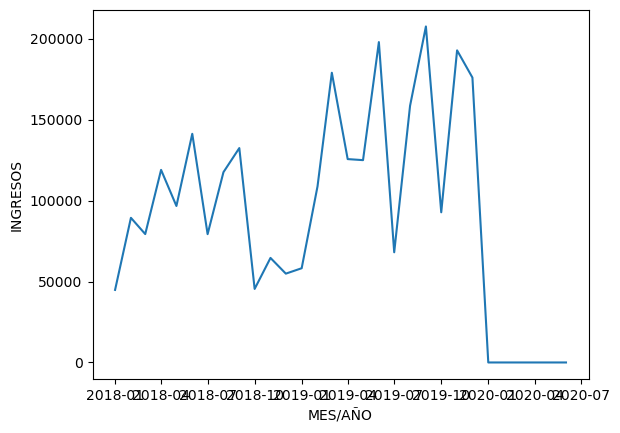

In [163]:
# draw lineplot
#pio.renderers.default = 'notebook'
sns.lineplot(x="MES/AÑO", y="INGRESOS", data=df[(df['TIPO CLIENTES'] == 'CLIENTES GRANDES') & (df['PRODUCTO'] == 'A1')])

In [164]:
df

,MES/AÑO,TIPO CLIENTES,PRODUCTO,PRECIO POR TON (USD),MARCA,INVERSION,% TIENDAS IMPACTADAS,DIAS HABILES,TEMPERATURA,INFLACION,VENTAS (TON),VENTAS (PESOS),INVERSION (PESOS),INGRESOS
0,2018-01-01,CLIENTES GRANDES,A1,11974.78,MARCA1,0.3296,0.93,22,22.2,0.18,5.583,66855.20,22035.47,44819.73
1,2018-01-01,CLIENTES GRANDES,A2,16001.06,MARCA2,0.2392,1.00,22,22.2,0.18,41.297,660795.77,158062.35,502733.42
2,2018-01-01,CLIENTES GRANDES,A3,17422.30,MARCA2,0.2552,0.84,22,22.2,0.18,2.553,44479.13,11351.07,33128.06
3,2018-01-01,CLIENTES GRANDES,A4,13909.82,MARCA1,0.2642,0.99,22,22.2,0.18,36.454,507068.58,133967.52,373101.06
4,2018-01-01,CLIENTES GRANDES,A5,16142.56,MARCA3,0.2246,0.94,22,22.2,0.18,13.793,222654.33,50008.16,172646.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,2020-06-01,CLIENTES PEQUEÑOS,A20,10749.63,MARCA1,0.3324,0.57,22,16.4,1.10,0.000,0.00,0.00,0.00
1383,2020-06-01,CLIENTES PEQUEÑOS,A21,8750.97,MARCA1,0.2366,0.63,22,16.4,1.10,0.000,0.00,0.00,0.00
1384,2020-06-01,CLIENTES PEQUEÑOS,A22,16789.52,MARCA1,0.1711,0.33,22,16.4,1.10,0.000,0.00,0.00,0.00
1385,2020-06-01,CLIENTES PEQUEÑOS,A23,12336.52,MARCA6,0.4000,0.70,22,16.4,1.10,0.000,0.00,0.00,0.00


Income after investment from big clients, grouped by product 

In [139]:
#This cell only works on vsc with extension 'jupyter notebook renders' due structure of plotly.express library.
try:
        pio.renderers.default = 'browser'
        fig = px.line(df[df['TIPO CLIENTES'] == 'CLIENTES GRANDES'], x="MES/AÑO", y="INGRESOS", title='Ingresos después de inversión (clientes grandes) desglosado por producto', color='PRODUCTO')
        fig.show()
except:
        logger.info('This cell only works on vsc with extension "jupyter notebook renders" due structure of plotly.express library.')

Income after investment from small clients, grouped by product 

In [140]:
#This cell only works on vsc with extension 'jupyter notebook renders' due structure of plotly.express library.
try:
        pio.renderers.default = 'browser'
        fig = px.line(df[df['TIPO CLIENTES'] == 'CLIENTES PEQUEÑOS'], x="MES/AÑO", y="INGRESOS", title='Ingresos después de inversión (clientes pequeños) desglosado por producto', color='PRODUCTO')
        fig.show()
except:
        logger.info('This cell only works on vsc with extension "jupyter notebook renders" due structure of plotly.express library.')

In [264]:
df.to_csv('../input/Datos_df.csv', index = False)

## Model testing and validation

For the test phase, only one product of one type of client will be used (case: A1 product from big clients)

In [192]:
df_seasonal = df[(df['TIPO CLIENTES'] == 'CLIENTES GRANDES') & (df['PRODUCTO'] == 'A1')].copy(deep = True)
df_seasonal = df_seasonal[['MES/AÑO','VENTAS (PESOS)']].set_index('MES/AÑO')

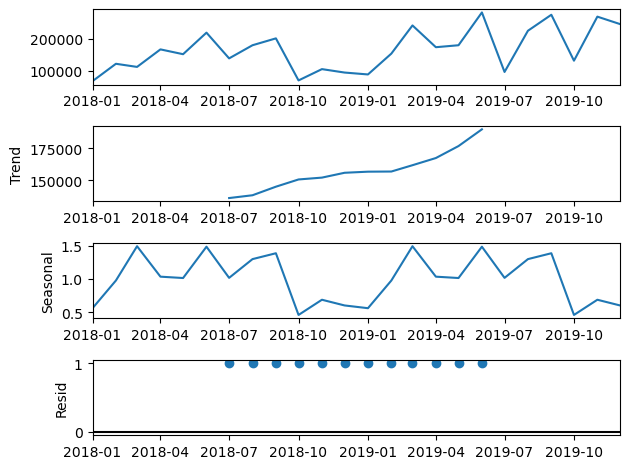

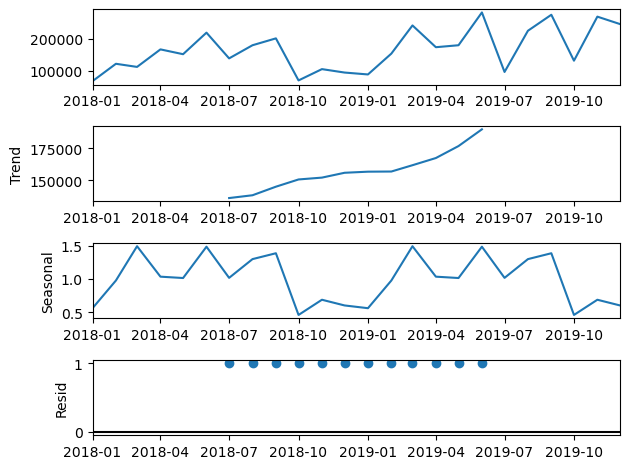

In [193]:
decompose_result = seasonal_decompose(df_seasonal[df_seasonal.index < '2020-01-01'],model='multiplicative')
decompose_result.plot()

After looking at seasonal is presumed annual seasonality. The next step is develop a model to validate this assumption

In [194]:
df_before2020 = df_seasonal[df_seasonal.index < '2020-01-01'].copy(deep = True)

<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='MES/AÑO'>

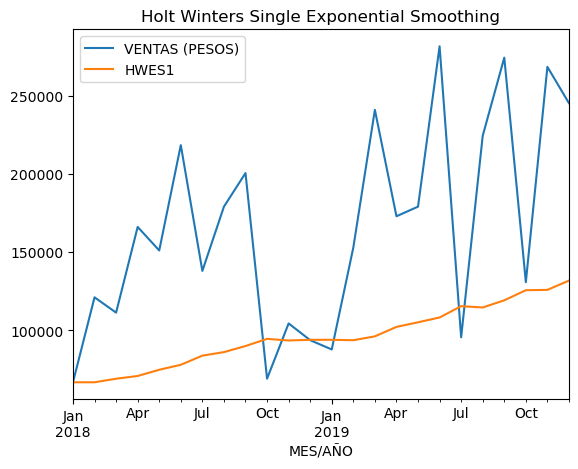

In [196]:
# Set the value of Alpha and define m (Time Period)
df_before2020.index.freq = 'MS'
m = 12
alpha = 1/(2*m)
df_before2020['HWES1'] = SimpleExpSmoothing(df_before2020['VENTAS (PESOS)']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
df_before2020[['VENTAS (PESOS)','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

due that simple exponential smoothing doesn´t fit to real values is going to be discard this option

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='MES/AÑO'>

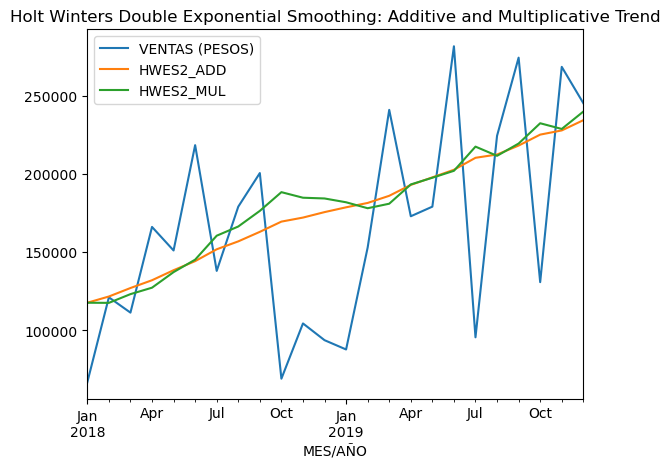

In [197]:
df_before2020['HWES2_ADD'] = ExponentialSmoothing(df_before2020['VENTAS (PESOS)'],trend='add').fit().fittedvalues
df_before2020['HWES2_MUL'] = ExponentialSmoothing(df_before2020['VENTAS (PESOS)'],trend='mul').fit().fittedvalues
df_before2020[['VENTAS (PESOS)','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')

In the previous graph can be observed that neither additive or multiplicative trend from double exponential smooothing is fitting to real sales.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='MES/AÑO'>

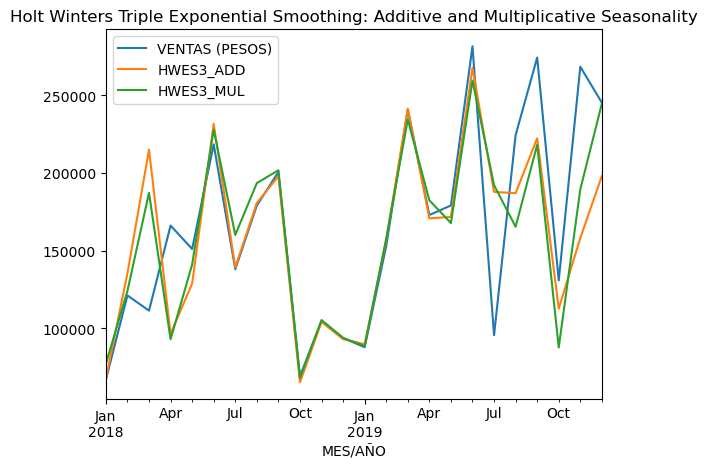

In [198]:
df_before2020['HWES3_ADD'] = ExponentialSmoothing(df_before2020['VENTAS (PESOS)'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df_before2020['HWES3_MUL'] = ExponentialSmoothing(df_before2020['VENTAS (PESOS)'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df_before2020[['VENTAS (PESOS)','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

By empiric observation is clear that triple exponential smoothing fit close enough to real sales, but by simple observation both approaches have similar results (additive and multiplicative), for that reason is necessary to validate which one is better. additionally to that is necessary to calculate MAE, MSE and MAPE to evaluate the model.

In [256]:
logger.info('Mean Absolute Error additive= %s',mean_absolute_error(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_ADD']))
logger.info('Mean Absolute Error multiplicative= %s',mean_absolute_error(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_MUL']))

INFO:log:Mean Absolute Error additive= 25876.907982208515
INFO:log:Mean Absolute Error multiplicative= 25423.543848840996


By minimal diference in mean absolute error the multiplicative trend is better.

In [254]:
df_mse = pd.merge(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_ADD'],  how = 'left', on = 'MES/AÑO')
df_mse['DIF_^2'] = (df_mse['VENTAS (PESOS)'] - df_mse['HWES3_ADD'])**2
df_mse['MAPE'] = abs(df_mse['VENTAS (PESOS)'] - df_mse['HWES3_ADD']) / df_mse['VENTAS (PESOS)']
logger.info('Mean Squared Error = %s', df_mse['DIF_^2'].sum() / len(df_mse['DIF_^2']))
logger.info('Mean Absolute Percentage Error = %s', df_mse['MAPE'].sum() * 1/len(df_mse['MAPE']))

INFO:log:Mean Squared Error = 1835462995.7739427
INFO:log:Mean Absolute Percentage Error = 0.166664160999561


In [255]:
df_mse_m = pd.merge(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_MUL'],  how = 'left', on = 'MES/AÑO')
df_mse_m['DIF_^2'] = (df_mse_m['VENTAS (PESOS)'] - df_mse_m['HWES3_MUL'])**2
df_mse_m['MAPE'] = abs(df_mse_m['VENTAS (PESOS)'] - df_mse_m['HWES3_MUL']) / df_mse_m['VENTAS (PESOS)']
logger.info('Mean Squared Error = %s', df_mse_m['DIF_^2'].sum() / len(df_mse_m['DIF_^2']))
logger.info('Mean Absolute Percentage Error = %s', df_mse_m['MAPE'].sum() * 1/len(df_mse_m['MAPE']))

INFO:log:Mean Squared Error = 1537347293.6002457
INFO:log:Mean Absolute Percentage Error = 0.16851944016187845


In MSE there is a significative difference, being better for multiplicative trend. In addition to that MAPE metric is similar in both trends, despite there is 16.8% of error is acceptable for this situation, since the actual error rate in delivery/production is 33%. In further sprints I would recommend to collect daily data to develop a second version of the model in order to reduce the MAPE.

In [215]:
#Split df to validate model
df_seasonal.index.freq = 'MS'
df_train = df_seasonal[df_seasonal.index < '2020-01-01']
df_test = df_seasonal[df_seasonal.index >= '2020-01-01']

In [211]:
logger.info(len(df_train))
logger.info(len(df_test))

INFO:log:24
INFO:log:6


c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Text(0.5, 1.0, 'Train and Predicted Test using Holt Winters')

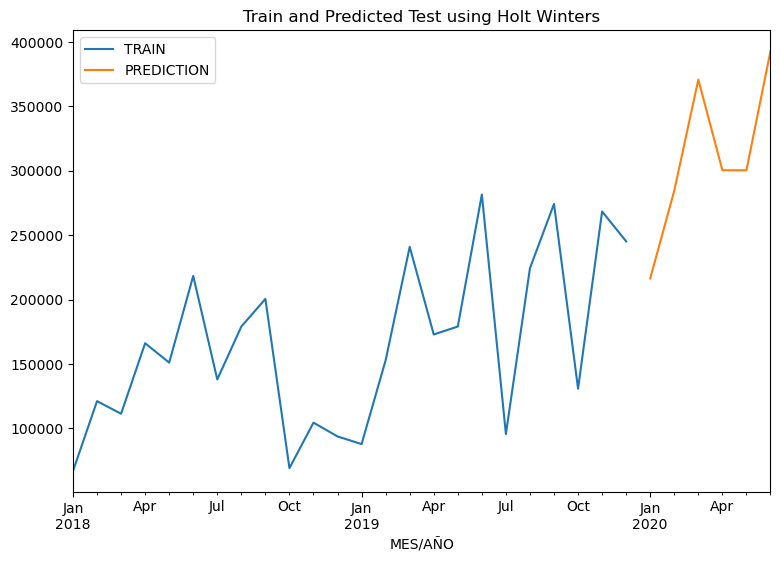

In [222]:
fitted_model = ExponentialSmoothing(df_train['VENTAS (PESOS)'],trend='add',seasonal='add',seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(6)
df_train['VENTAS (PESOS)'].plot(legend=True,label='TRAIN')
test_predictions.plot(legend=True,label='PREDICTION',figsize=(9,6))
plt.title('Train and Predicted Test using Holt Winters')

The orange line is the sales predictions (pesos unit) for the next six months, starting in January 2020. The blue line is the actual data (Jan 2018 - Dec 2019)

In [236]:
logger.info('Mean Absolute Error = %s',mean_absolute_error(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_ADD']))
logger.info('Mean Squared Error = %s',mean_squared_error(df_before2020['VENTAS (PESOS)'], df_before2020['HWES3_ADD']))
#logger.info('Mean Squared Error = %s', mean_squared_error(test_airline,test_predictions))

Mean Absolute Error =  25876.907982208515
Mean Squared Error =  1835462995.7739427


In [237]:
df_before2020['VENTAS (PESOS)'].sum()

3972803.7699999996

#### Running predictions for full data

In [287]:
list_data = []
tipos_clientes = df['TIPO CLIENTES'].unique()
producto = df['PRODUCTO'].unique()
for i in tipos_clientes:
    for j in producto:
        df_seasonal = df[(df['TIPO CLIENTES'] == i) & (df['PRODUCTO'] == j)].set_index('MES/AÑO').copy(deep = True)
        df_predict = df_seasonal[df_seasonal.index >= '2020-01-01'].copy(deep = True)
        df_seasonal = df_seasonal[df_seasonal.index < '2020-01-01'].copy(deep = True)

        if len(df_seasonal) >= 24:
            df_seasonal['HWES3_MUL'] = ExponentialSmoothing(df_seasonal['VENTAS (PESOS)'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
            fitted_model = ExponentialSmoothing(df_train['VENTAS (PESOS)'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
            test_predictions = fitted_model.forecast(6)
            df_predict['HWES3_MUL'] = test_predictions
            df_seasonal = [df_seasonal, df_predict]
            df_seasonal = pd.concat(df_seasonal)
            #df_seasonal[['VENTAS (PESOS)','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')  # plot every predictions of the model
            #test_predictions.plot(legend=True,label='PREDICTION',figsize=(9,6))  # plot actual predictions for 2020
            list_data.append(df_seasonal)
        else:
            logger.info(i + ' ' + j)
            logger.info(len(df_seasonal))
df_full_predict = pd.concat(list_data)
df_full_predict
#df_seasonal = df_seasonal[['MES/AÑO','VENTAS (PESOS)']].set_index('MES/AÑO')

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\David\anaconda3\envs\tallarines_env\lib\site-packages\statsmod

,TIPO CLIENTES,PRODUCTO,PRECIO POR TON (USD),MARCA,INVERSION,% TIENDAS IMPACTADAS,DIAS HABILES,TEMPERATURA,INFLACION,VENTAS (TON),VENTAS (PESOS),INVERSION (PESOS),INGRESOS,HWES3_MUL
MES/AÑO,,,,,,,,,,,,,,
2018-01-01,CLIENTES GRANDES,A1,11974.78,MARCA1,0.3296,0.93,22,22.2,0.18,5.583,66855.20,22035.47,44819.73,7.705462e+04
2018-02-01,CLIENTES GRANDES,A1,11591.00,MARCA1,0.2624,0.93,20,23.0,0.48,10.449,121114.36,31780.41,89333.95,1.240483e+05
2018-03-01,CLIENTES GRANDES,A1,11928.65,MARCA1,0.2878,0.91,20,22.5,0.97,9.334,111342.02,32044.23,79297.79,1.871710e+05
2018-04-01,CLIENTES GRANDES,A1,11731.65,MARCA1,0.2838,0.93,21,20.9,0.84,14.156,166073.24,47131.59,118941.65,9.289162e+04
2018-05-01,CLIENTES GRANDES,A1,11784.40,MARCA1,0.3601,0.94,22,18.5,0.88,12.817,151040.65,54389.74,96650.91,1.410390e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,CLIENTES PEQUEÑOS,A23,12303.90,MARCA6,0.3716,0.72,20,23.0,0.17,0.000,0.00,0.00,0.00,5.481527e+05
2020-03-01,CLIENTES PEQUEÑOS,A23,12336.52,MARCA6,0.4000,0.70,22,22.5,0.78,0.000,0.00,0.00,0.00,9.640451e+05
2020-04-01,CLIENTES PEQUEÑOS,A23,13600.13,MARCA6,0.4728,0.74,22,20.9,0.82,0.000,0.00,0.00,0.00,8.459826e+05


In [288]:
df_full_predict.to_csv('../input/Datos_full_predict.csv')